In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [3]:
import numpy as np
import pandas as pd
import pennylane as qml
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [17]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import KFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score
from datetime import timedelta


In [5]:
seed = 1503
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.set_floatx('float64')

<h1> Redes Neurais Quânticas </h1>

<p>Definindo o circuito TwoLocal </p>

In [6]:
def TwoLocal(n_qubits, theta, reps = 1):
    
    for r in range(reps):
        for i in range(n_qubits):
            qml.RY(theta[r * n_qubits + i], wires = i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for i in range(n_qubits):
        qml.RY(theta[reps * n_qubits + i], wires = i)

<p>Define Hermitiana para medição do circuito</p>

In [7]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

print(M)

[[1 0]
 [0 0]]


<p>Define numero de qubits, de repetições do Two Local, theta e simulador</p>

In [8]:
n_qubits = 5
k_repetitions = 3
theta = {"theta": n_qubits * (k_repetitions + 1)}
dev = qml.device("lightning.qubit", wires=n_qubits)

<p>Define rede neural com Codificação no Eixo X e VQC Two Local</p>

In [9]:
@qml.qnode(dev, interface="tf")
def qnn_x(inputs, theta):
    qml.AngleEmbedding(inputs, range(n_qubits), rotation='X')
    TwoLocal(n_qubits, theta, reps=k_repetitions)
    return qml.expval(qml.Hermitian(M, wires=[0]))

<p>Define rede neural com Codificação no Eixo Y e VQC Two Local</p>

In [10]:
@qml.qnode(dev, interface="tf")
def qnn_y(inputs, theta):
    qml.AngleEmbedding(inputs, range(n_qubits), rotation="Y")
    TwoLocal(n_qubits, theta, reps=k_repetitions)
    return qml.expval(qml.Hermitian(M, wires=[0]))

<p>Define rede neural com Codificação no Eixo Y e VQC Two Local</p>

In [11]:
@qml.qnode(dev, interface="tf")
def qnn_z(inputs, theta):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    qml.AngleEmbedding(inputs, range(n_qubits), rotation="Z")
    TwoLocal(n_qubits, theta, reps=k_repetitions)
    return qml.expval(qml.Hermitian(M, wires=[0]))

<h3>Visualizando os circuitos</h3>

C:\Users\mathe\AppData\Local\Temp\ipykernel_4928\2534974028.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


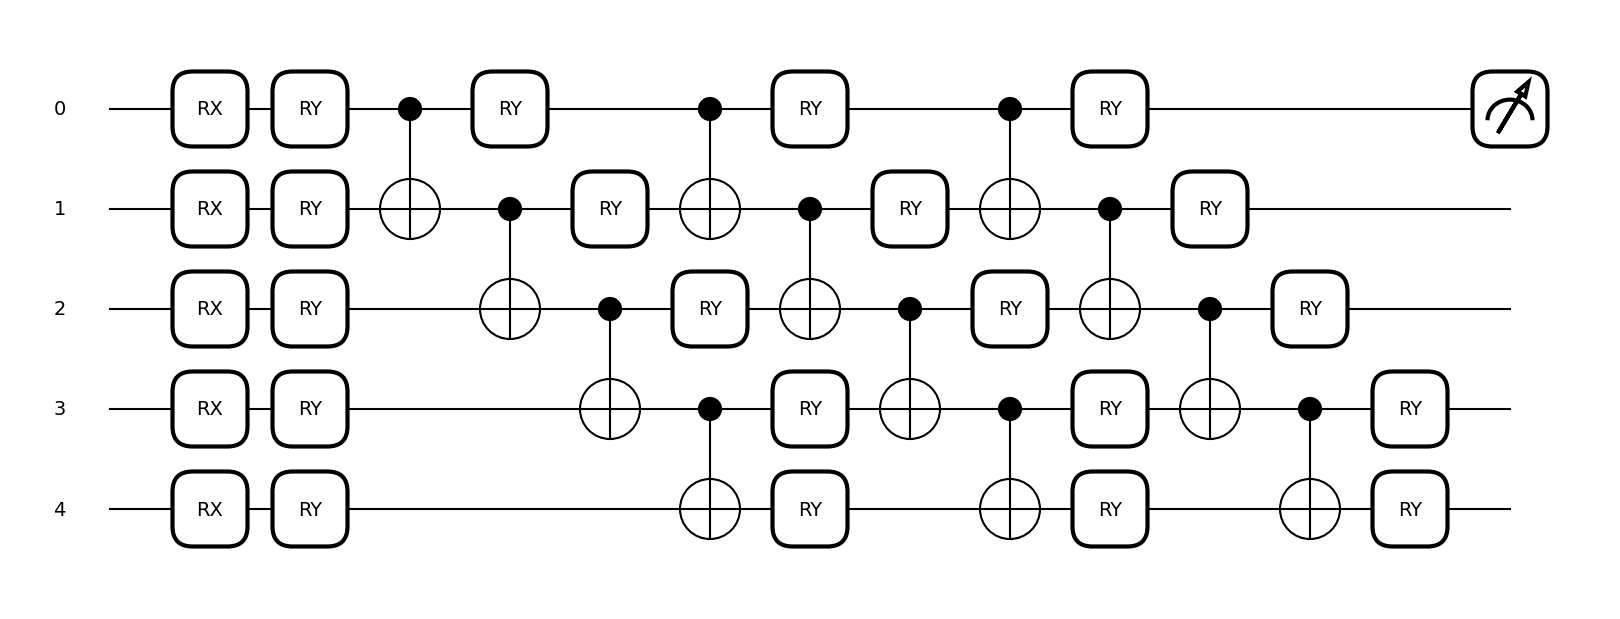

In [14]:
fig, ax = qml.draw_mpl(qnn_x, expansion_strategy='device')(range(5), range(25))
fig.show()

C:\Users\mathe\AppData\Local\Temp\ipykernel_4928\1295373040.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


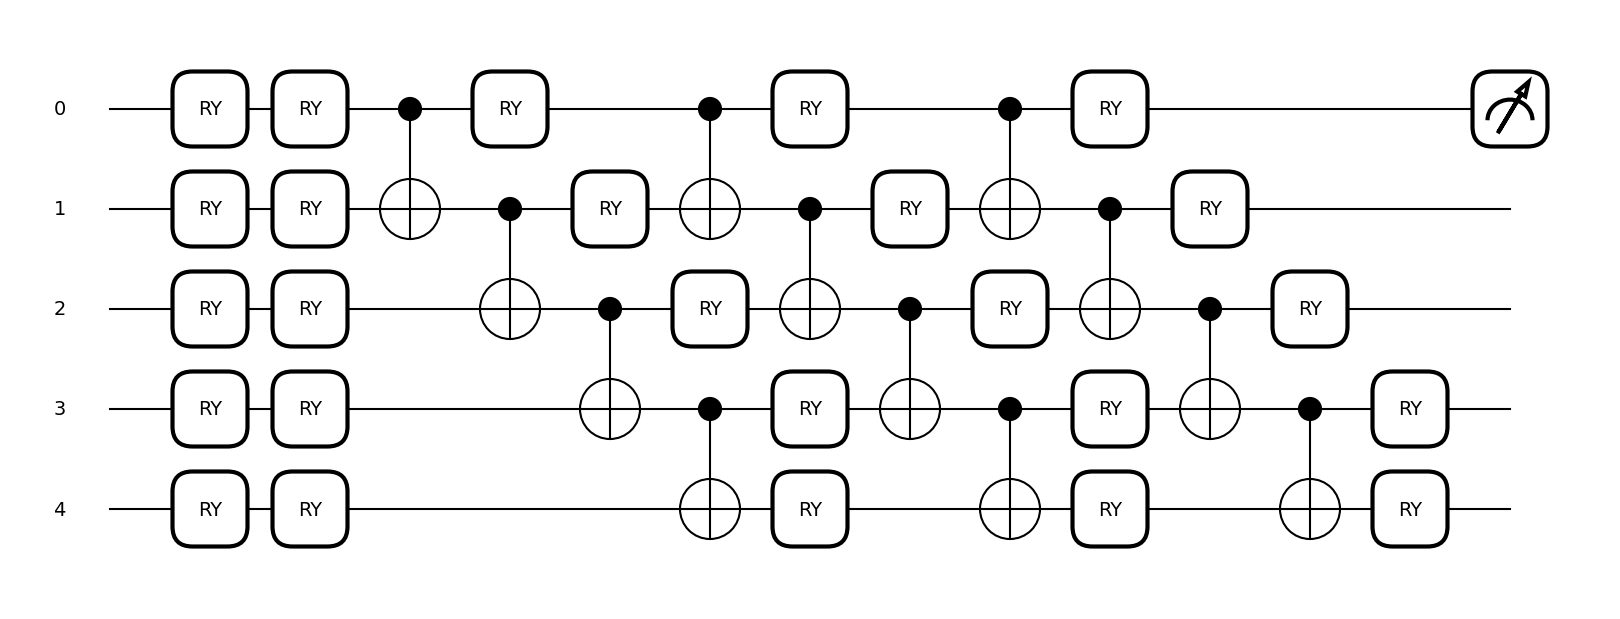

In [15]:
fig, ax = qml.draw_mpl(qnn_y, expansion_strategy='device')(range(5), range(25))
fig.show()

C:\Users\mathe\AppData\Local\Temp\ipykernel_4928\3291073080.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


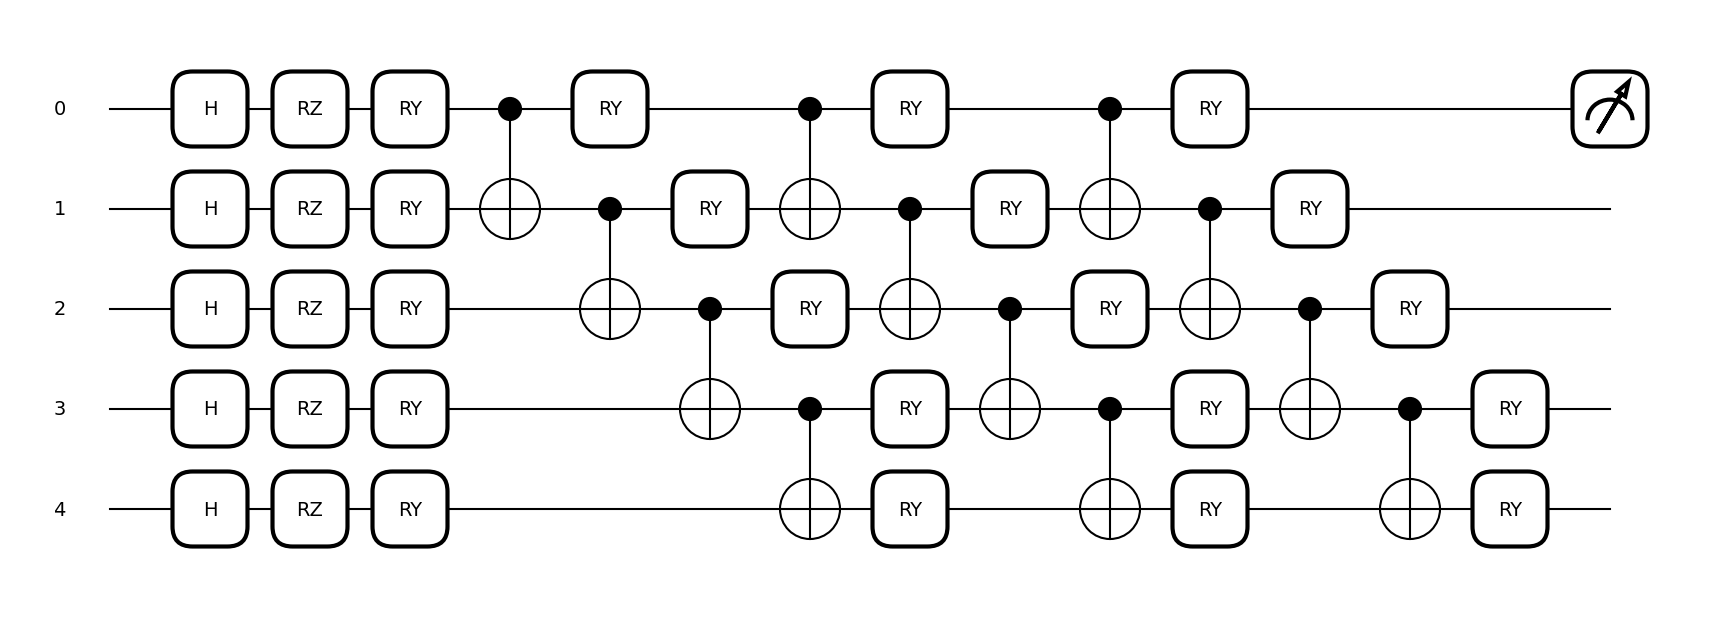

In [16]:
fig, ax = qml.draw_mpl(qnn_z, expansion_strategy='device')(range(5), range(25))
fig.show()

<h3>Definindo os modelos híbridos</h3>

<p>Definindo modelos da rede neural parametrizável</p>

In [12]:
model_q = lambda vqc, act, classic: tf.keras.Sequential(
    [tf.keras.layers.Input(15)]
    + ([tf.keras.layers.Dense(n_qubits, activation = act)] if not classic 
       else [tf.keras.layers.Dense(n_qubits, activation = act), tf.keras.layers.Dense(n_qubits, activation = act)]) 
    + ([qml.qnn.KerasLayer(vqc, weight_shapes=theta, output_dim=1)] if not classic 
       else [tf.keras.layers.Dense(1, activation = "softmax")]))
    

<p>Define parada para barren plateau</P>

In [ ]:
model_Q5 = lambda vqc, act, classic: tf.keras.Sequential(
    tf.keras.layers.Input(5),
    qml.qnn.KerasLayer(vqc, weight_shapes=theta, output_dim=1))

In [13]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 2, verbose = 1,
    restore_best_weights = True)

<h2>Breast Cancer Dataset</h2>

In [31]:
data = load_breast_cancer()
X,y = data.data, 1 - data.target
feature_names = data.feature_names

In [32]:
# Tamanho do dataset
print(f"Número de amostras: {X.shape[0]}")
print(f"Número de características: {X.shape[1]}")

# Classes alvo
print(f"Classes: {np.unique(y)}")
print(f"Distribuição das classes:\n{pd.Series(y).value_counts(normalize=True)}")

Número de amostras: 569
Número de características: 30
Classes: [0 1]
Distribuição das classes:
0    0.627417
1    0.372583
Name: proportion, dtype: float64


In [33]:
df = pd.DataFrame(X, columns=feature_names)

correlations = df.corrwith(pd.Series(y))
sorted_correlations = correlations.sort_values(ascending=False)

print("Top 15 características mais relevantes:")
print(sorted_correlations.head(15))

Top 15 características mais relevantes:
worst concave points    0.793566
worst perimeter         0.782914
mean concave points     0.776614
worst radius            0.776454
mean perimeter          0.742636
worst area              0.733825
mean radius             0.730029
mean area               0.708984
mean concavity          0.696360
worst concavity         0.659610
mean compactness        0.596534
worst compactness       0.590998
radius error            0.567134
perimeter error         0.556141
area error              0.548236
dtype: float64


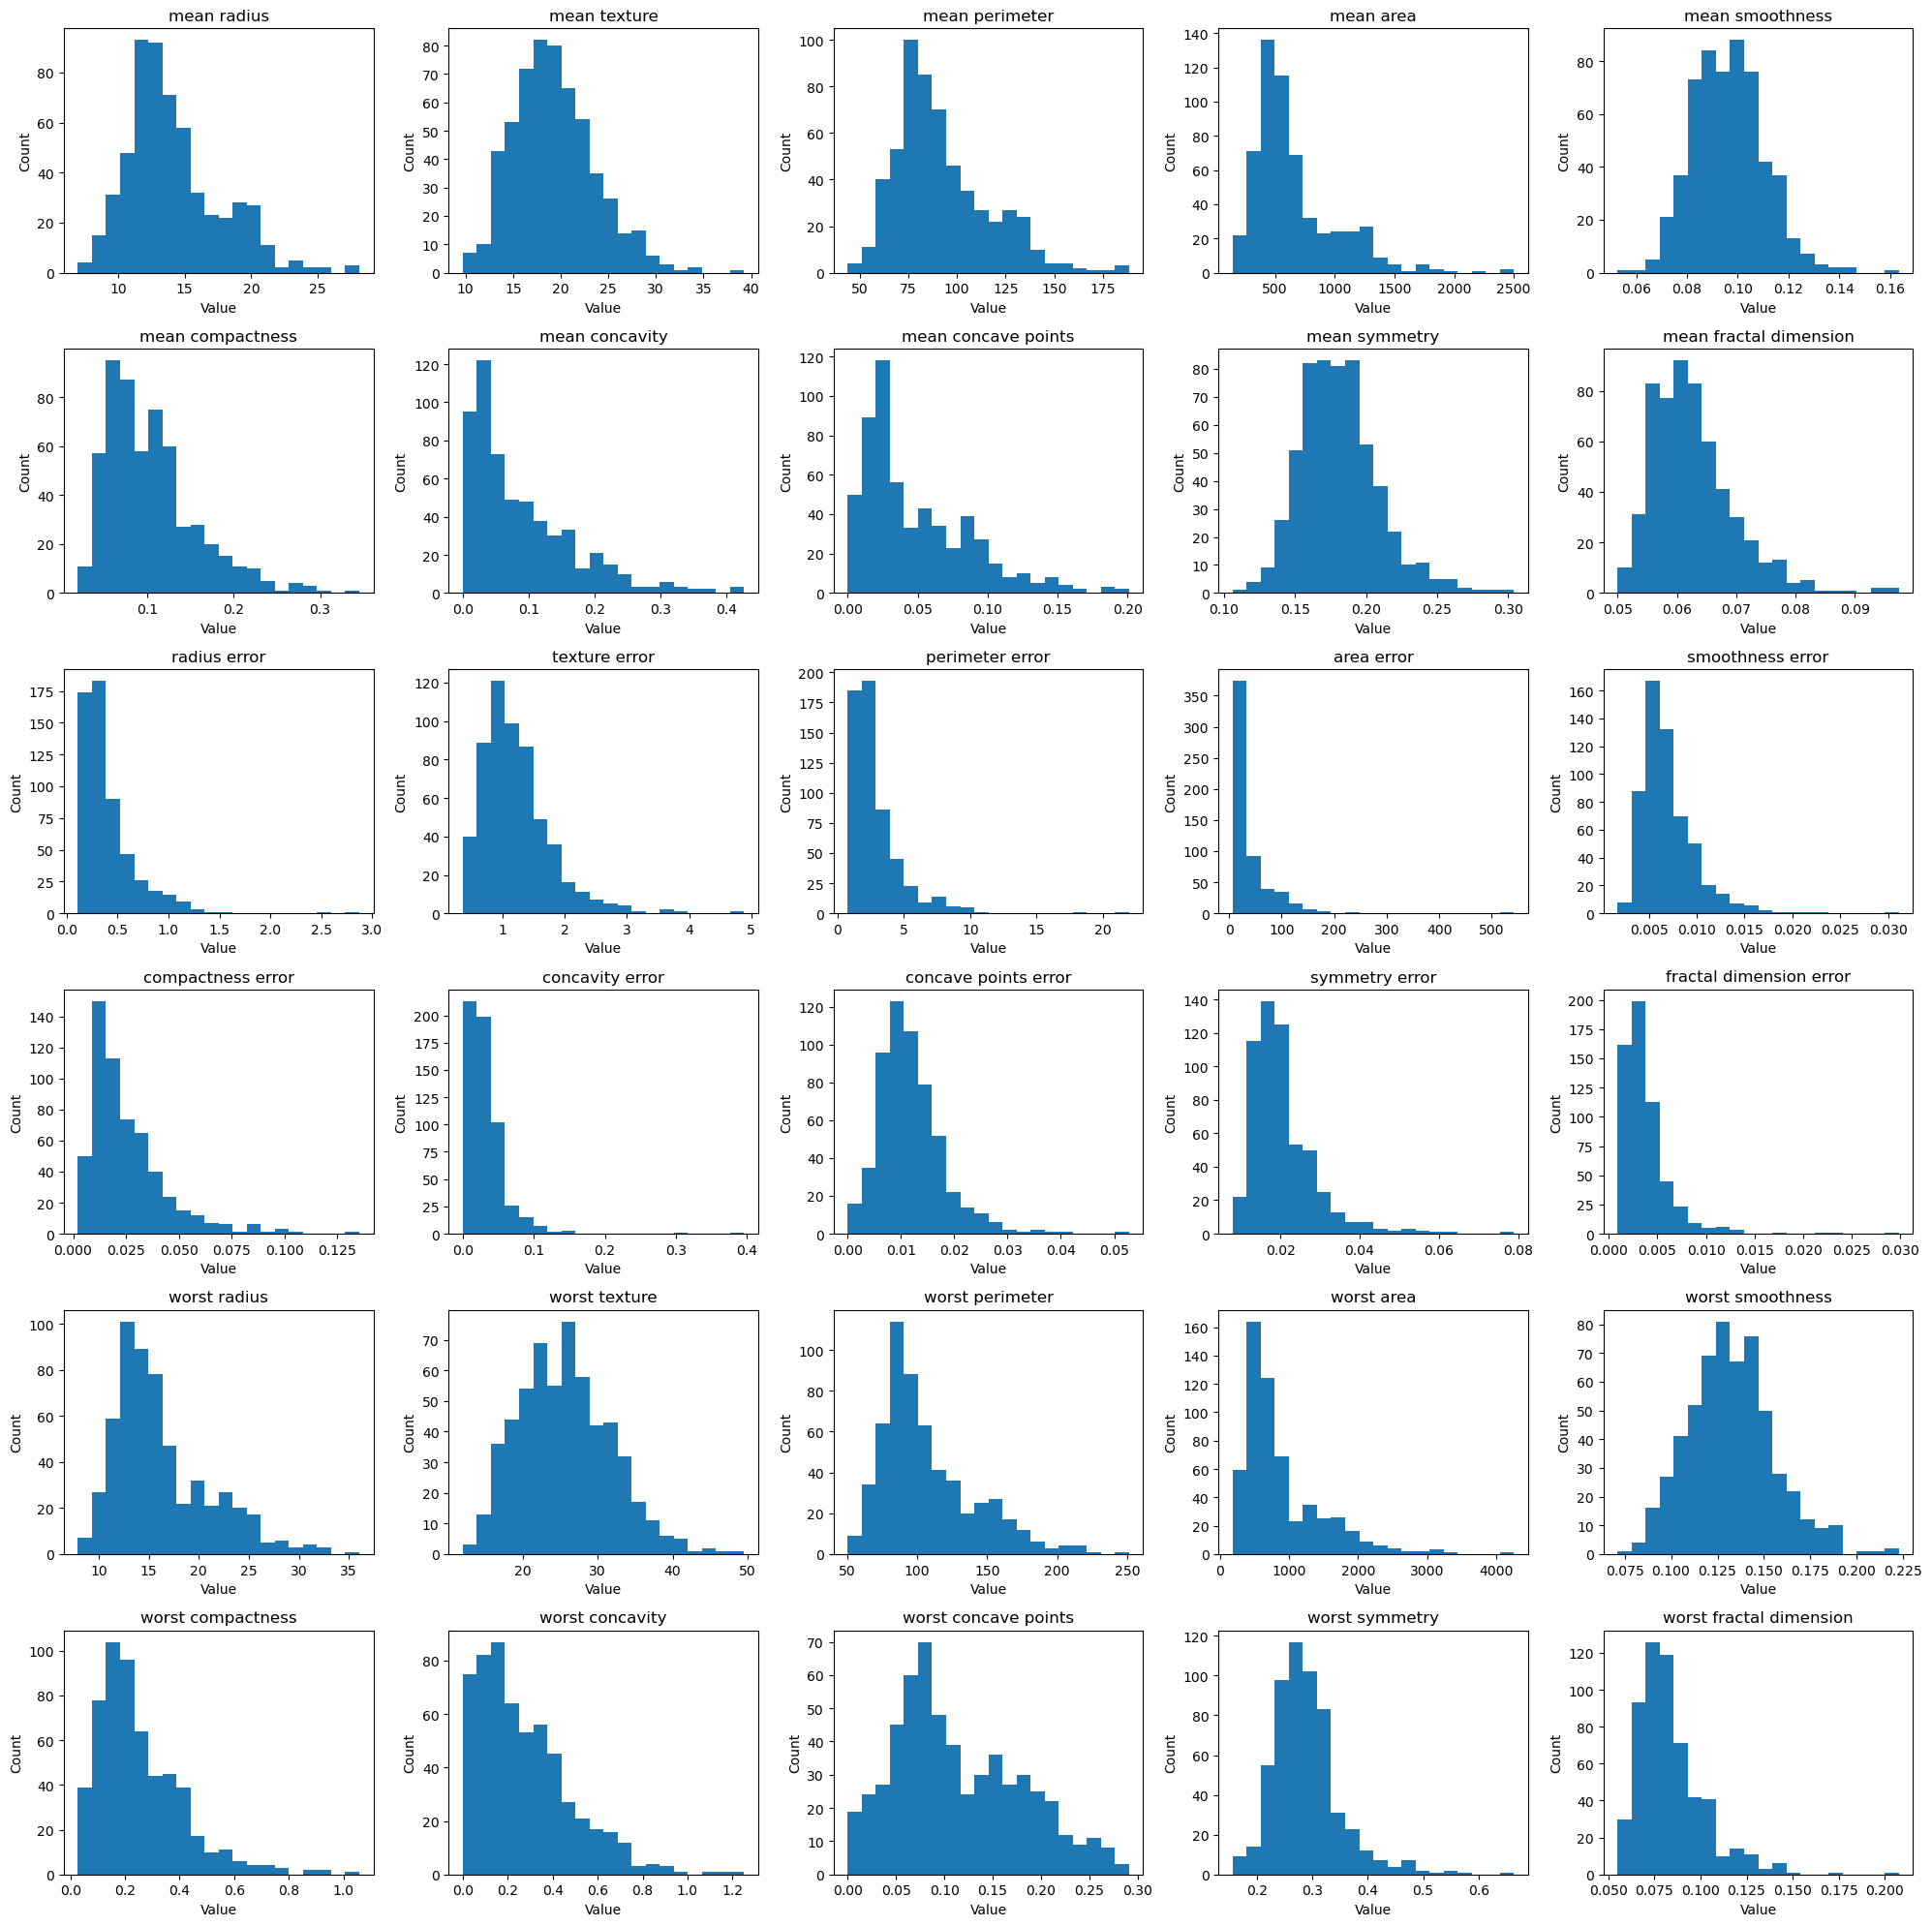

In [29]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 20))
axs = axs.flatten()

for i, feature in enumerate(feature_names):
    axs[i].hist(df[feature], bins=20)
    axs[i].set_title(feature)
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

<h4>Pré processamento </h4>

<p>Define características por maior correlação</p>

In [22]:
top_15_features = sorted_correlations.iloc[1:16].index.tolist()
x = df[top_15_features]

<p>Poe os dados entre 0 e PI</p>

In [23]:
scaler = MaxAbsScaler()
x = scaler.fit_transform(x)
xq = np.clip(x, 0, np.pi)
xc = np.clip(x, 0, 1)


<p>Define KFold e gráfico de perda</p>

In [24]:
kf = KFold(n_splits=5, shuffle=True)

In [25]:
def plot_losses(history):
    tr_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = np.array(range(len(tr_loss))) + 1
    plt.plot(epochs, tr_loss, label = "Training loss")
    plt.plot(epochs, val_loss, label = "Validation loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [55]:
import statistics
def treina_kfold(data_X, get_model, vqc, act, classic, batch_size = 15):
    history, losses, train_accuracies, val_accuracies, times= [], [], [], [], []
    model = None
    fold_no = 1
    
    for train_index, val_index in kf.split(data_X, y):
        tf.keras.backend.clear_session()
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
        loss = tf.keras.losses.BinaryCrossentropy()

        print(f"Fold #{fold_no}")

        model = get_model(vqc, act, classic)
        model.compile(optimizer, loss=loss)
        
        X_train, X_val = data_X[train_index], data_X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        start = time.time()
        h = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, 
                                 validation_data=(X_val, y_val), verbose=0)
        end = time.time()

        history.append(h)

        print("Time:", timedelta(seconds= (end - start)))
        times.append(end-start)
        print("Loss:", h.history['loss'][-1])
        losses.append(h.history['loss'][-1])
        
        val_acc = accuracy_score(model.predict(X_val) >= 0.5, y_val)
        train_acc = accuracy_score(model.predict(X_train) >= 0.5, y_train)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        val_score = model.evaluate(X_val, y_val, verbose=0)
        train_score = model.evaluate(X_train, y_train, verbose=0)
        
        print(f"Train score: {train_score} \n      accuracy:{train_acc}")
        print(f"Validation score: {val_score} \n        accuracy:{val_acc}")

        plot_losses(h)

        fold_no += 1

    model.summary()
    
    print(f'Mean loss: {statistics.mean(losses)}')
    print(f'Std loss: {statistics.stdev(losses)}')

    print(f'Mean train acc: {statistics.mean(train_accuracies)}')
    print(f'Std train acc: {statistics.stdev(train_accuracies)}')


    print(f'Mean val acc: {statistics.mean(val_accuracies)}')
    print(f'Std val acc: {statistics.stdev(val_accuracies)}')

    print(f'Mean time: {timedelta(seconds= (statistics.mean(times)))}')

    return history

<h3>Treina Modelo QX</h3>

Fold #1
Time: 0:07:35.728706
Loss: 0.1520587650085208
15/15 [==============================] - 3s 197ms/step
Train score: 0.15077927109304365 
      accuracy:0.9384615384615385
Validation score: 0.16012656492622276 
        accuracy:0.9649122807017544


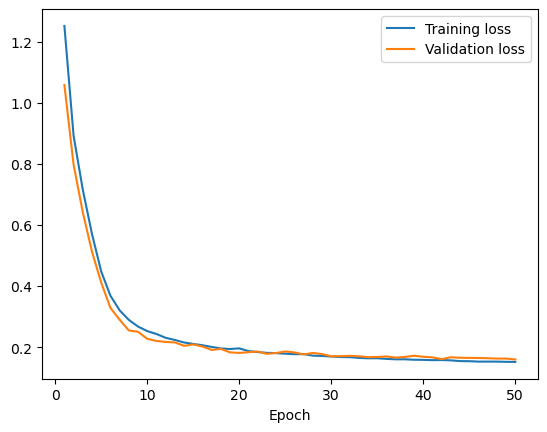

Fold #2
Time: 0:07:33.818298
Loss: 0.15273436631202264
15/15 [==============================] - 3s 168ms/step
Train score: 0.15181145132570475 
      accuracy:0.9560439560439561
Validation score: 0.22163726467835276 
        accuracy:0.8947368421052632


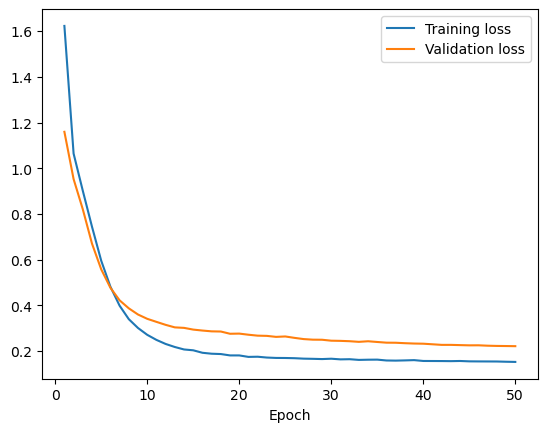

Fold #3
Time: 0:07:30.696087
Loss: 0.16342604002149147
15/15 [==============================] - 3s 194ms/step
Train score: 0.16216351086949254 
      accuracy:0.9538461538461539
Validation score: 0.2110583000538642 
        accuracy:0.9385964912280702


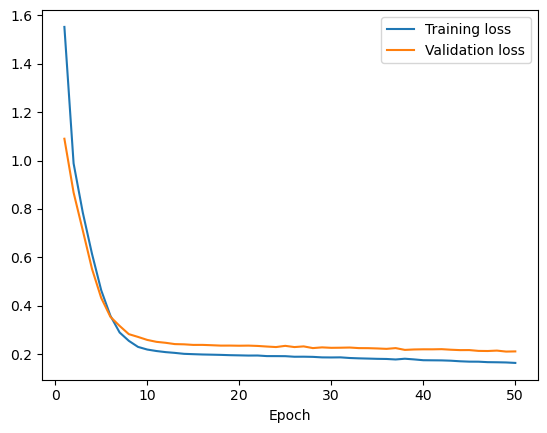

Fold #4
Time: 0:07:31.173956
Loss: 0.16716742185950578
15/15 [==============================] - 3s 172ms/step
Train score: 0.1656736841241082 
      accuracy:0.9384615384615385
Validation score: 0.15401576642404524 
        accuracy:0.9649122807017544


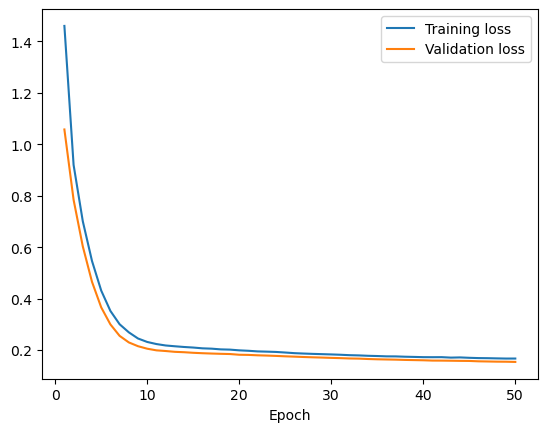

Fold #5
Time: 0:07:32.995973
Loss: 0.1775563747280523
15/15 [==============================] - 3s 173ms/step
Train score: 0.17534760777887545 
      accuracy:0.9407894736842105
Validation score: 0.1462430742989599 
        accuracy:0.9557522123893806


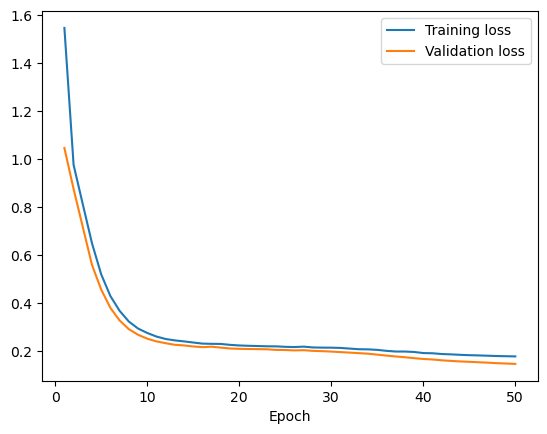

Mean loss: 0.1625885935859186
Std loss: 0.010649935941652965
Mean train acc: 0.9455205320994795
Std train acc: 0.008690513866762319
Mean val acc: 0.9437820214252446
Std val acc: 0.029447328078528113
Mean time: 0:07:32.882604


In [61]:
h_qx = treina_kfold(xq, model_q, qnn_x, None, False)

<h3>Treina Modelo QY</h3>

Fold #1
Time: 0:07:37.053512
Loss: 0.15588989191146935
15/15 [==============================] - 3s 173ms/step
Train score: 0.15477783643937373 
      accuracy:0.9516483516483516
Validation score: 0.15960261382554708 
        accuracy:0.9385964912280702


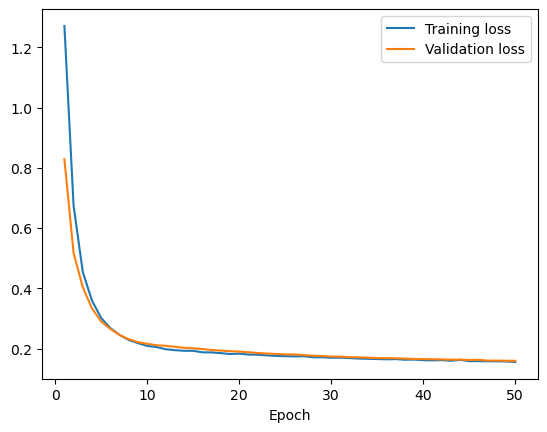

Fold #2
Time: 0:07:57.976203
Loss: 0.14394727169606797
15/15 [==============================] - 3s 185ms/step
Train score: 0.1431708876330119 
      accuracy:0.9560439560439561
Validation score: 0.20434449952945374 
        accuracy:0.8947368421052632


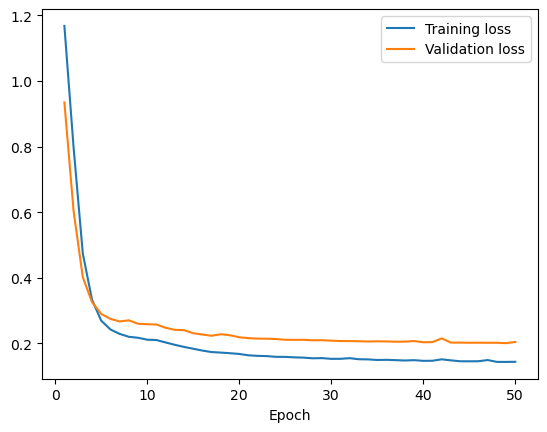

Fold #3
Time: 0:07:55.093623
Loss: 0.15686769585385593
15/15 [==============================] - 3s 175ms/step
Train score: 0.15587262707752186 
      accuracy:0.9494505494505494
Validation score: 0.13135417668442978 
        accuracy:0.9736842105263158


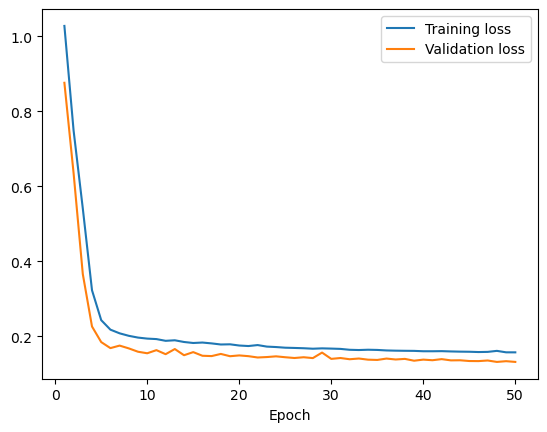

Fold #4
Time: 0:07:32.402919
Loss: 0.146411046154871
15/15 [==============================] - 3s 202ms/step
Train score: 0.14516255547712137 
      accuracy:0.9428571428571428
Validation score: 0.19015672907494663 
        accuracy:0.9385964912280702


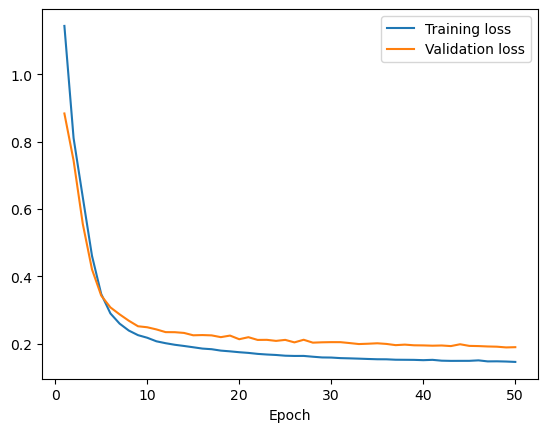

Fold #5
Time: 0:07:31.377234
Loss: 0.16567405620294656
15/15 [==============================] - 3s 176ms/step
Train score: 0.16444955661631466 
      accuracy:0.9451754385964912
Validation score: 0.10892980868837475 
        accuracy:0.9646017699115044


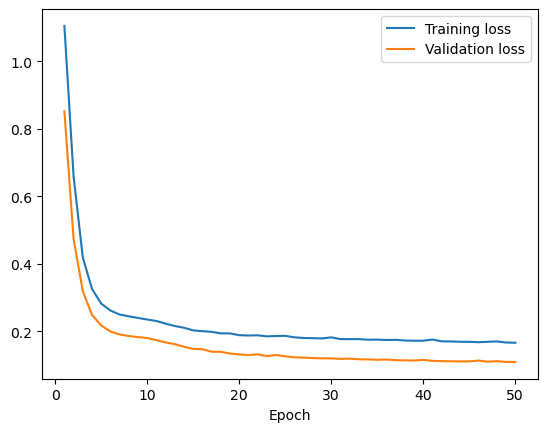

Mean loss: 0.15375799236384216
Std loss: 0.00875265227678439
Mean train acc: 0.9490350877192982
Std train acc: 0.005224698222778877
Mean val acc: 0.9420431609998448
Std val acc: 0.03070705832358816
Mean time: 0:07:42.780698


In [63]:
h_qy = treina_kfold(xq, model_q, qnn_y, None, False)

<h3>Treina Modelo QZ</h3>

Fold #1
Time: 0:07:29.900044
Loss: 0.20034193867570285
15/15 [==============================] - 3s 172ms/step
Train score: 0.19937820313396035 
      accuracy:0.9274725274725275
Validation score: 0.27475863512147936 
        accuracy:0.8859649122807017


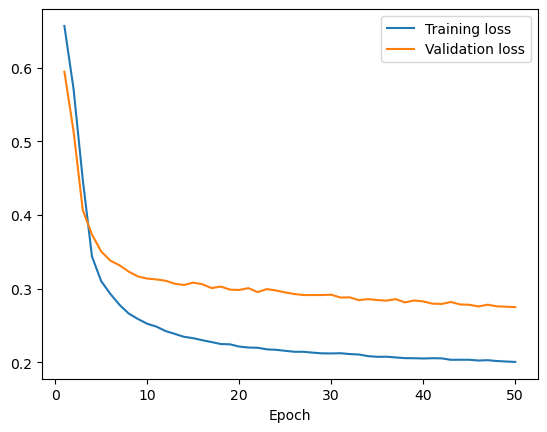

Fold #2
Time: 0:07:27.793688
Loss: 0.169570953561121
15/15 [==============================] - 3s 173ms/step
Train score: 0.1663735740541757 
      accuracy:0.9428571428571428
Validation score: 0.1333791660635095 
        accuracy:0.9736842105263158


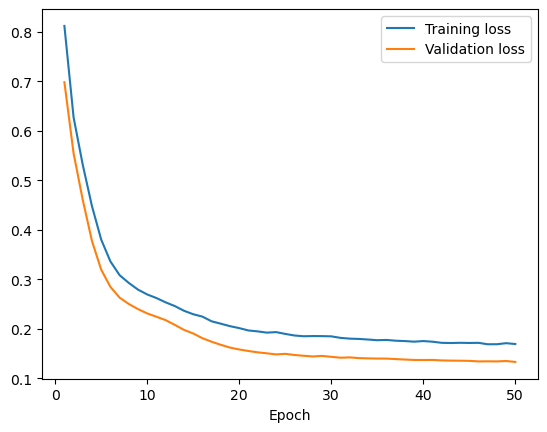

Fold #3
Time: 0:07:22.140212
Loss: 0.20431333750633915
15/15 [==============================] - 3s 174ms/step
Train score: 0.2031486430993447 
      accuracy:0.9230769230769231
Validation score: 0.23791731109744624 
        accuracy:0.9035087719298246


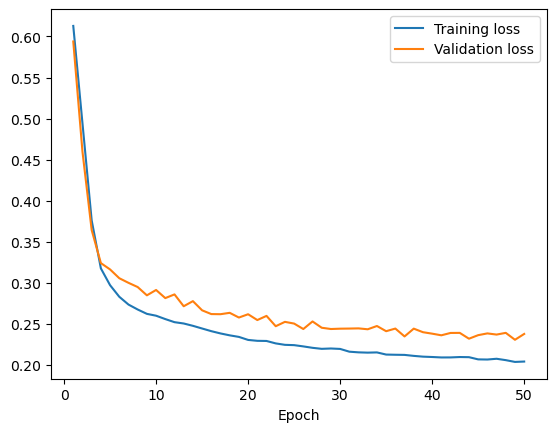

Fold #4
Time: 0:07:10.409937
Loss: 0.17155087133062466
15/15 [==============================] - 3s 170ms/step
Train score: 0.17045620190245764 
      accuracy:0.9428571428571428
Validation score: 0.13944763075887112 
        accuracy:0.9649122807017544


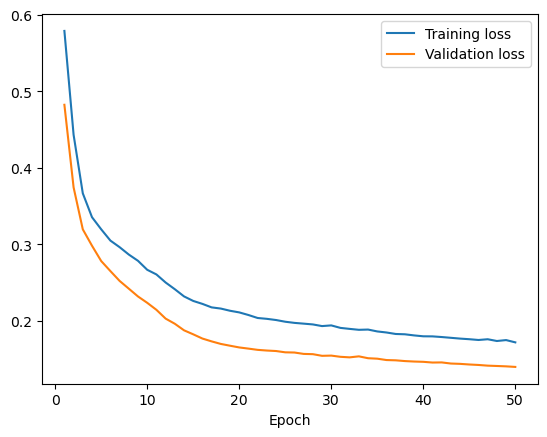

Fold #5
Time: 0:07:09.024123
Loss: 0.21101809869380828
15/15 [==============================] - 3s 202ms/step
Train score: 0.20829799248461137 
      accuracy:0.9298245614035088
Validation score: 0.2270521422666786 
        accuracy:0.9026548672566371


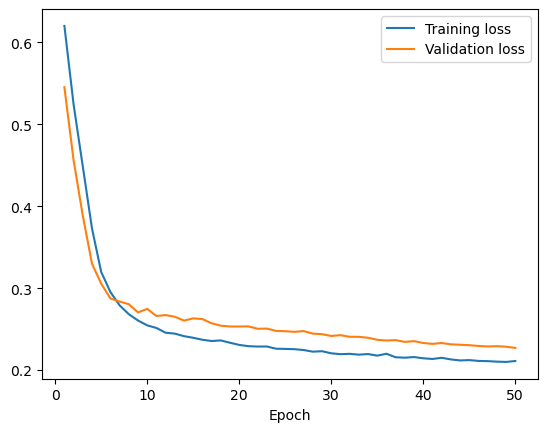

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 80        
                                                                 
 keras_layer (KerasLayer)    (None, 1)                 20        
                                                                 
Total params: 100 (800.00 Byte)
Trainable params: 100 (800.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Mean loss: 0.1913590399535192
Std loss: 0.01937826835613655
Mean train acc: 0.933217659533449
Std train acc: 0.009126793942741997
Mean val acc: 0.9261450085390467
Std val acc: 0.040129487902133575
Mean time: 0:07:19.853601


In [107]:
h_qy = treina_kfold(xq, model_q, qnn_z, None, False)

<h3>Treina Modelo Clássico</h3>


Fold #1

Time: 0:00:20.156867
Loss: 0.07567160330780137
15/15 [==============================] - 0s 1ms/step
Train score: 0.06630915597793617 
      accuracy:0.3626373626373626
Validation score: 0.07665816147164056 
        accuracy:0.41228070175438597


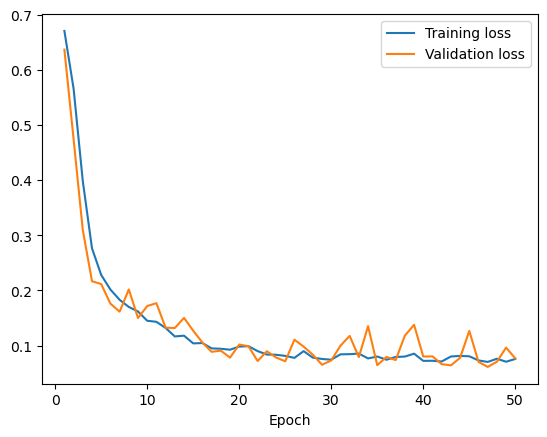

Fold #2
Time: 0:00:05.089290
Loss: 0.09753071294953944
15/15 [==============================] - 0s 992us/step
Train score: 0.06629185558690896 
      accuracy:0.3802197802197802
Validation score: 0.12125048114863714 
        accuracy:0.34210526315789475


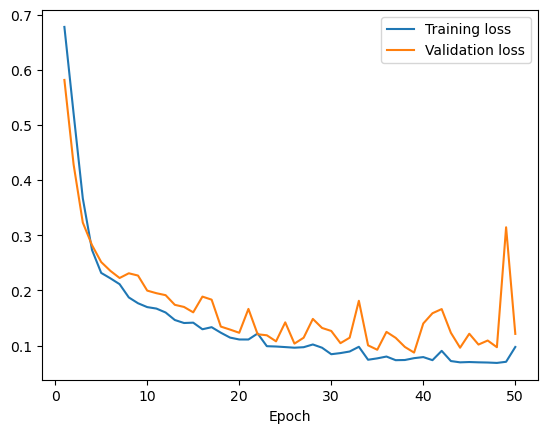

Fold #3
Time: 0:00:04.982464
Loss: 0.0688381397788919
15/15 [==============================] - 0s 1ms/step
Train score: 0.07079670556040182 
      accuracy:0.3824175824175824
Validation score: 0.16030169760266208 
        accuracy:0.3333333333333333


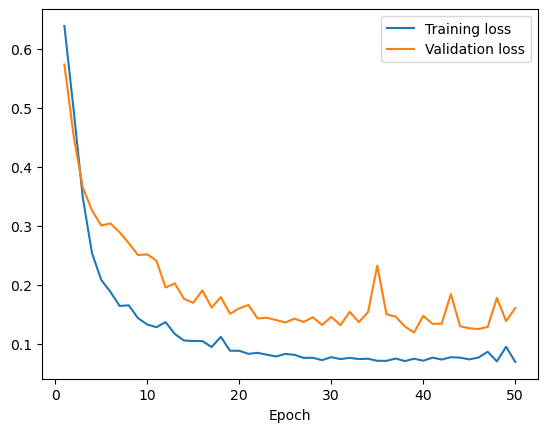

Fold #4
Time: 0:00:05.014664
Loss: 0.07648367102725818
15/15 [==============================] - 0s 1ms/step
Train score: 0.07697797258047304 
      accuracy:0.3648351648351648
Validation score: 0.06260430742086952 
        accuracy:0.40350877192982454


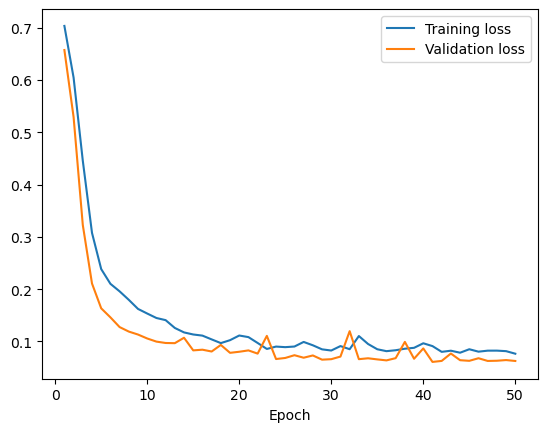

Fold #5
Time: 0:00:04.982315
Loss: 0.09256571532044452
15/15 [==============================] - 0s 1ms/step
Train score: 0.0801814394041059 
      accuracy:0.37280701754385964
Validation score: 0.051243529406511 
        accuracy:0.37168141592920356


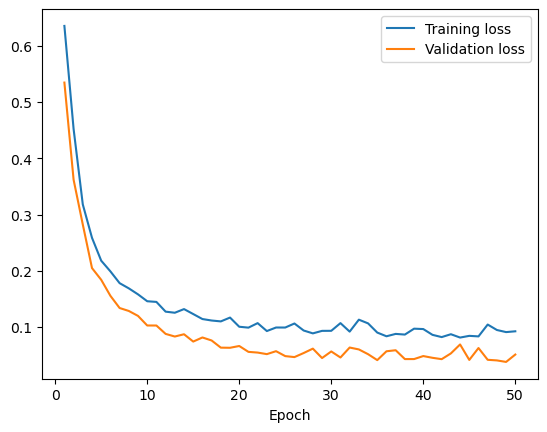

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 80        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 116 (928.00 Byte)
Trainable params: 116 (928.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Mean loss: 0.08221796847678708
Std loss: 0.012209759295115452
Mean train acc: 0.37258338153074994
Std train acc: 0.008860505895208811
Mean val acc: 0.37258189722092844
Std val acc: 0.035364362422687874
Mean time: 0:00:08.045120


In [29]:
h_qy = treina_kfold(xc, model_q, None, None, True)

<h3>Treina Modelo ReLu QX</h3>

Fold #1
Time: 0:07:05.353988
Loss: 0.1730489676476497
15/15 [==============================] - 3s 167ms/step
Train score: 0.1718089100587499 
      accuracy:0.9428571428571428
Validation score: 0.26839741855336907 
        accuracy:0.868421052631579


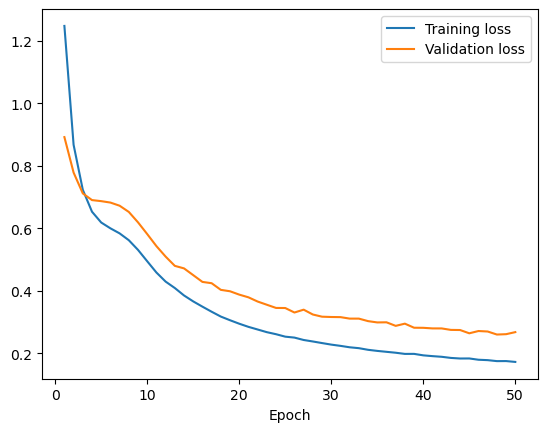

Fold #2
Time: 0:07:05.177967
Loss: 0.21672203326354286
15/15 [==============================] - 2s 161ms/step
Train score: 0.21443524825703966 
      accuracy:0.9208791208791208
Validation score: 0.21071878219382806 
        accuracy:0.9210526315789473


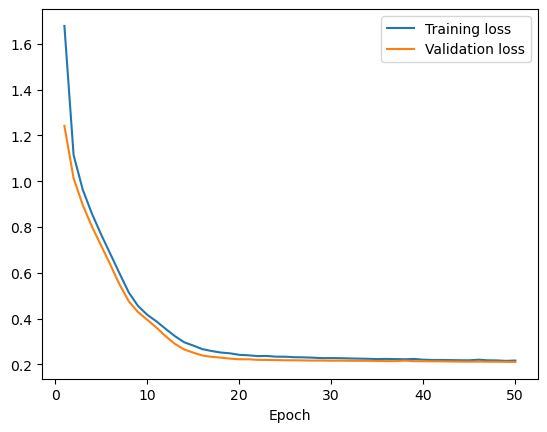

Fold #3
Time: 0:07:04.218240
Loss: 0.1980063069007204
15/15 [==============================] - 3s 167ms/step
Train score: 0.19643828053395826 
      accuracy:0.9296703296703297
Validation score: 0.2881789241443601 
        accuracy:0.9122807017543859


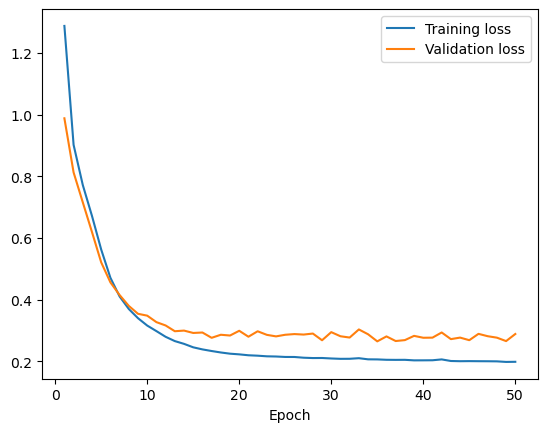

Fold #4
Time: 0:07:05.146067
Loss: 0.21980819471729482
15/15 [==============================] - 3s 202ms/step
Train score: 0.21815435447535672 
      accuracy:0.9142857142857143
Validation score: 0.18476099507850513 
        accuracy:0.956140350877193


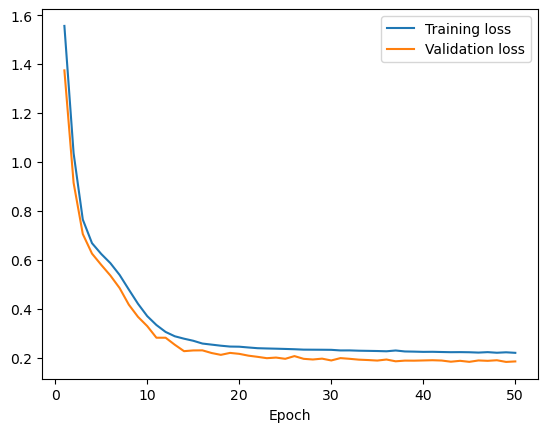

Fold #5
Time: 0:07:31.329499
Loss: 0.20700417816988878
15/15 [==============================] - 3s 178ms/step
Train score: 0.20564519444055723 
      accuracy:0.9144736842105263
Validation score: 0.17288823900497066 
        accuracy:0.9557522123893806


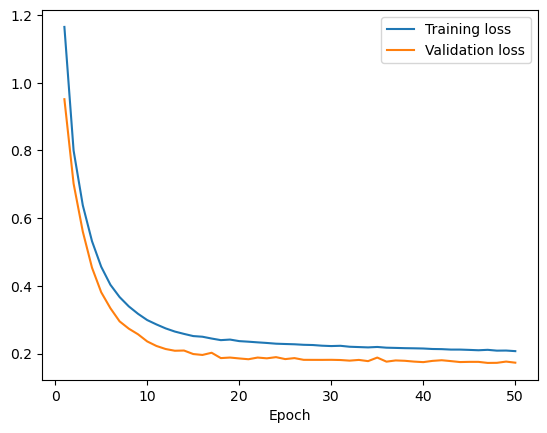

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 80        
                                                                 
 keras_layer (KerasLayer)    (None, 1)                 20        
                                                                 
Total params: 100 (800.00 Byte)
Trainable params: 100 (800.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Mean loss: 0.20291793613981932
Std loss: 0.018767063480417467
Mean train acc: 0.9244331983805668
Std train acc: 0.012058856673281437
Mean val acc: 0.9227293898462972
Std val acc: 0.03629111880982981
Mean time: 0:07:10.245152


In [108]:
h_qz = treina_kfold(xq, model_q, qnn_x, 'relu', False)

<h3>Treina Modelo ReLu QY</h3>

Fold #1
Time: 0:07:05.148898
Loss: 0.19835823653915313
15/15 [==============================] - 3s 171ms/step
Train score: 0.196516324366842 
      accuracy:0.9186813186813186
Validation score: 0.2914698678150512 
        accuracy:0.8947368421052632


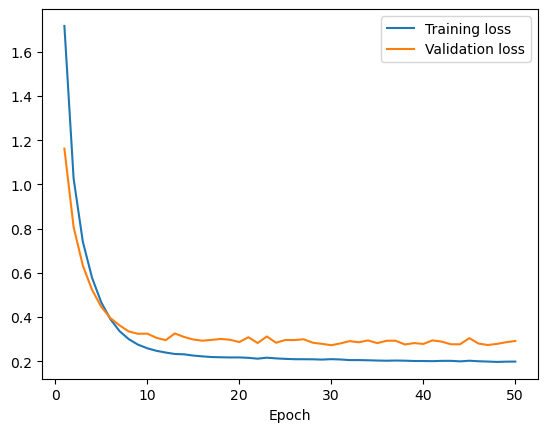

Fold #2
Time: 0:07:02.709085
Loss: 0.17301416564663818
15/15 [==============================] - 2s 163ms/step
Train score: 0.17128703600757725 
      accuracy:0.9406593406593406
Validation score: 0.1669327952621276 
        accuracy:0.9473684210526315


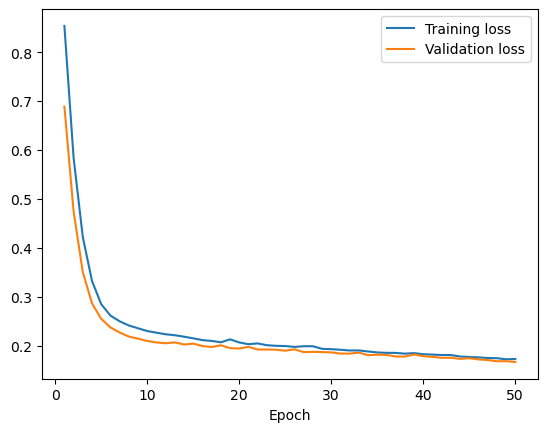

Fold #3
Time: 0:07:07.918932
Loss: 0.15258707211347186
15/15 [==============================] - 3s 170ms/step
Train score: 0.15104166067072322 
      accuracy:0.9472527472527472
Validation score: 0.1201698178784889 
        accuracy:0.9649122807017544


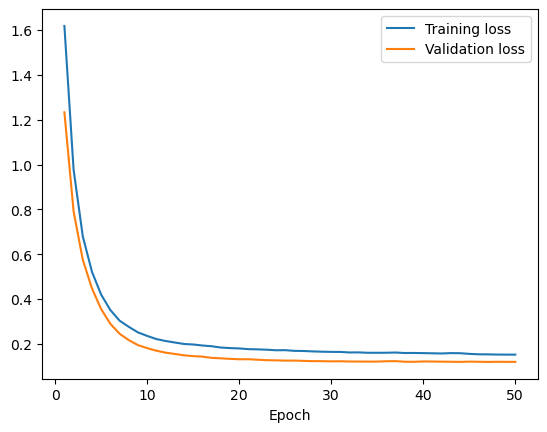

Fold #4
Time: 0:07:05.789982
Loss: 0.2375532443728032
15/15 [==============================] - 3s 166ms/step
Train score: 0.2347919266630005 
      accuracy:0.9274725274725275
Validation score: 0.24677780009152597 
        accuracy:0.9122807017543859


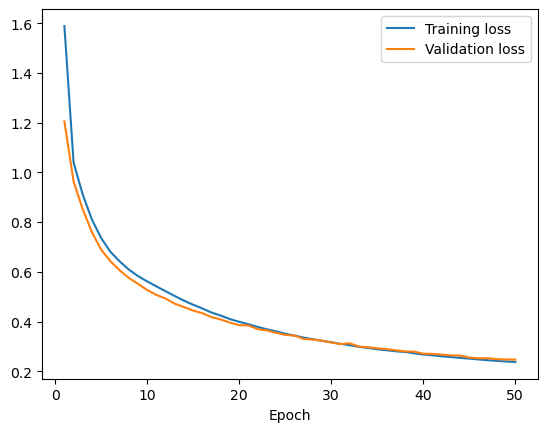

Fold #5
Time: 0:07:38.678765
Loss: 0.16419205709588622
15/15 [==============================] - 3s 191ms/step
Train score: 0.16291986628059754 
      accuracy:0.9451754385964912
Validation score: 0.1366257713695543 
        accuracy:0.9469026548672567


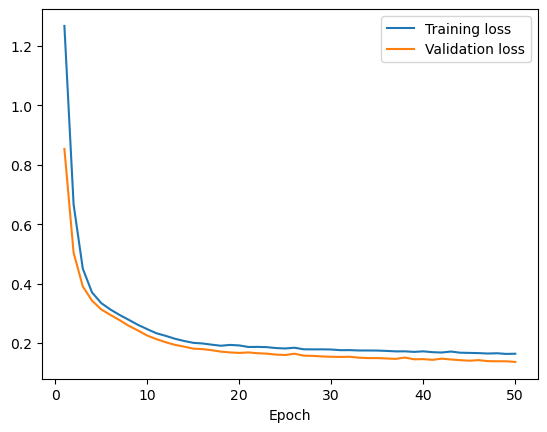

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 80        
                                                                 
 keras_layer (KerasLayer)    (None, 1)                 20        
                                                                 
Total params: 100 (800.00 Byte)
Trainable params: 100 (800.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Mean loss: 0.18514095515359053
Std loss: 0.033791327448737786
Mean train acc: 0.9358482745324851
Std train acc: 0.012299002569206106
Mean val acc: 0.9332401800962583
Std val acc: 0.028771509931555563
Mean time: 0:07:12.049132


In [111]:
h_relu_qx = treina_kfold(xq, model_q, qnn_y, 'relu', False)

<h3>Treina Modelo ReLu QZ</h3>

Fold #1
Time: 0:07:27.598091
Loss: 0.6634392053217282
15/15 [==============================] - 3s 184ms/step
Train score: 0.6631141187070491 
      accuracy:0.621978021978022
Validation score: 0.6500069938207927 
        accuracy:0.6491228070175439


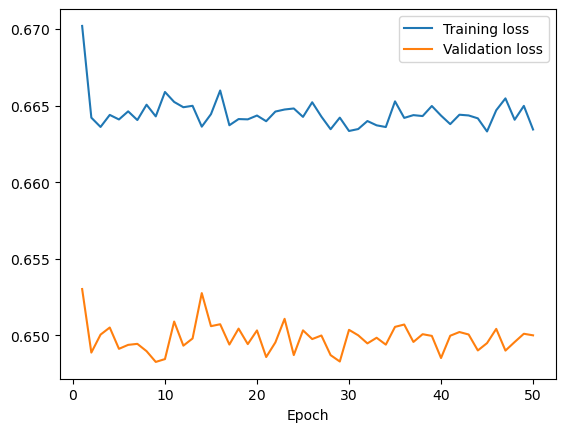

Fold #2
Time: 0:07:09.013979
Loss: 0.21846654649975192
15/15 [==============================] - 3s 170ms/step
Train score: 0.2170861934895044 
      accuracy:0.9296703296703297
Validation score: 0.22610641702225334 
        accuracy:0.9035087719298246


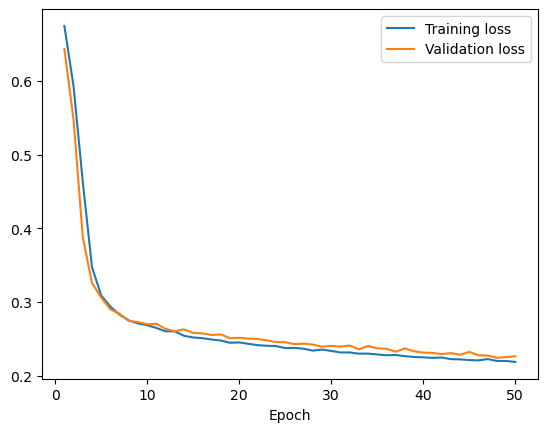

Fold #3
Time: 0:07:14.104153
Loss: 0.20399118455337148
15/15 [==============================] - 3s 184ms/step
Train score: 0.201438311790372 
      accuracy:0.9230769230769231
Validation score: 0.2044654590518851 
        accuracy:0.9210526315789473


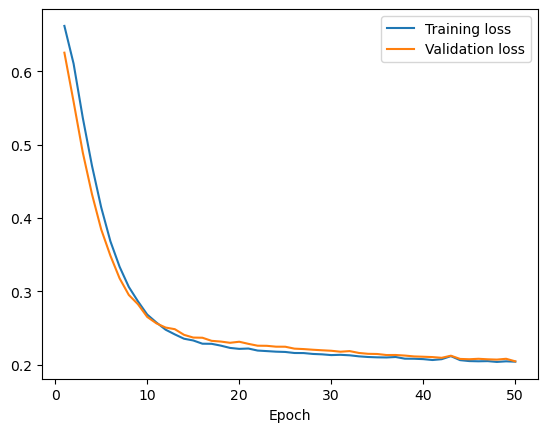

Fold #4
Time: 0:07:11.397822
Loss: 0.22412481757927877
15/15 [==============================] - 3s 172ms/step
Train score: 0.2232121882530359 
      accuracy:0.9252747252747253
Validation score: 0.18028225501378378 
        accuracy:0.9385964912280702


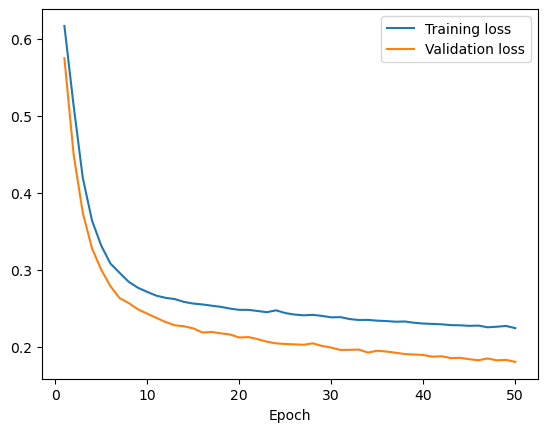

Fold #5
Time: 0:07:08.943281
Loss: 0.1946303473035214
15/15 [==============================] - 2s 165ms/step
Train score: 0.19356684360587806 
      accuracy:0.9320175438596491
Validation score: 0.27344072405743386 
        accuracy:0.9203539823008849


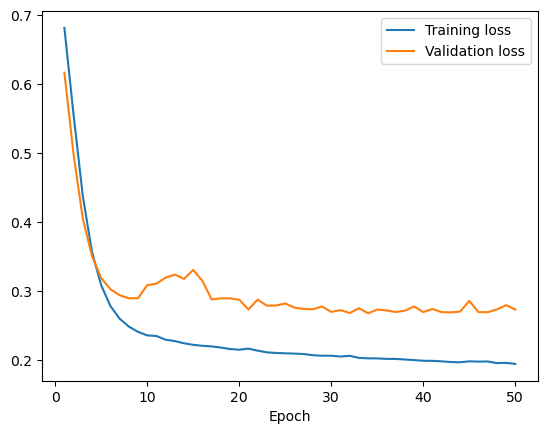

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 80        
                                                                 
 keras_layer (KerasLayer)    (None, 1)                 20        
                                                                 
Total params: 100 (800.00 Byte)
Trainable params: 100 (800.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Mean loss: 0.30093042025153033
Std loss: 0.20298333136957522
Mean train acc: 0.8664035087719298
Std train acc: 0.13668339954345765
Mean val acc: 0.8665269368110542
Std val acc: 0.12216447383545921
Mean time: 0:07:14.211465


In [110]:
h_relu_qz = treina_kfold(xq, model_q, qnn_z, 'relu', False)

<h3>Treina Modelo Clássico com ReLu</h3>

Fold #1
Time: 0:00:05.343681
Loss: 0.09311435479306683
15/15 [==============================] - 0s 1ms/step
Train score: 0.11730480775649484 
      accuracy:0.378021978021978
Validation score: 0.12388645756766693 
        accuracy:0.3508771929824561


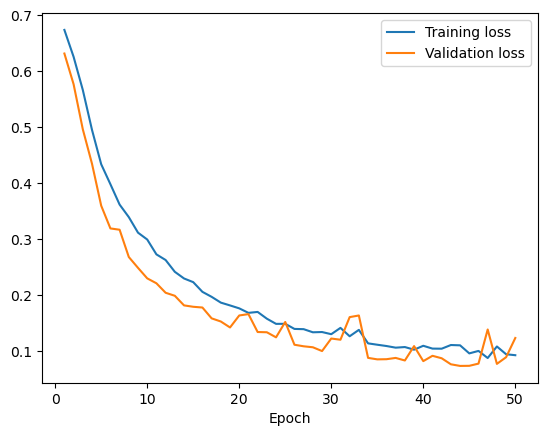

Fold #2
Time: 0:00:05.261128
Loss: 0.07918420487493379
15/15 [==============================] - 0s 1ms/step
Train score: 0.07642082706281697 
      accuracy:0.3648351648351648
Validation score: 0.07812425763426725 
        accuracy:0.40350877192982454


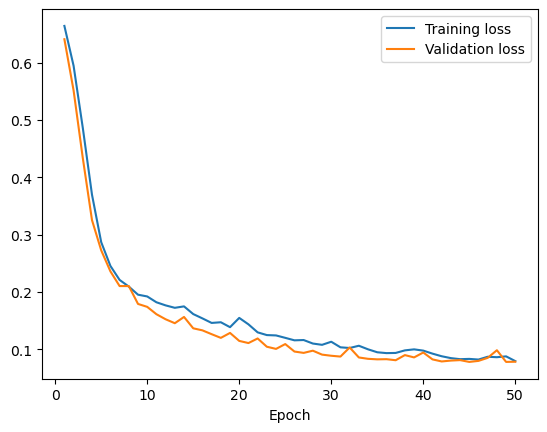

Fold #3
Time: 0:00:05.324140
Loss: 0.07676100417833452
15/15 [==============================] - 0s 1ms/step
Train score: 0.07225714354266605 
      accuracy:0.3758241758241758
Validation score: 0.06394266224566797 
        accuracy:0.35964912280701755


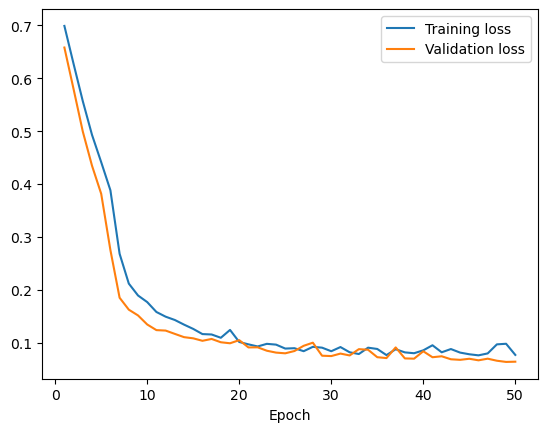

Fold #4
Time: 0:00:05.392504
Loss: 0.10286499813969852
15/15 [==============================] - 0s 1ms/step
Train score: 0.09947661983157978 
      accuracy:0.36923076923076925
Validation score: 0.08273696032692553 
        accuracy:0.38596491228070173


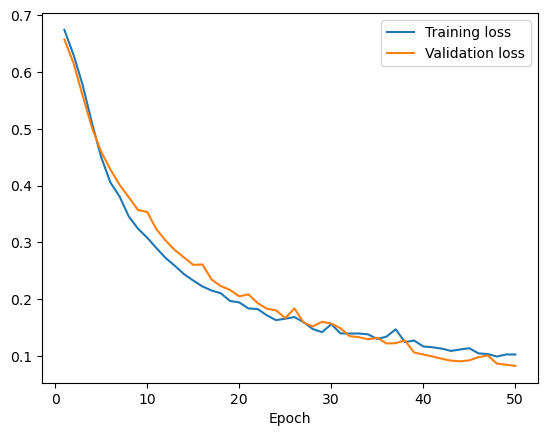

Fold #5
Time: 0:00:05.376591
Loss: 0.07338552513110547
15/15 [==============================] - 0s 1ms/step
Train score: 0.06919142388404712 
      accuracy:0.375
Validation score: 0.16900385368082413 
        accuracy:0.36283185840707965


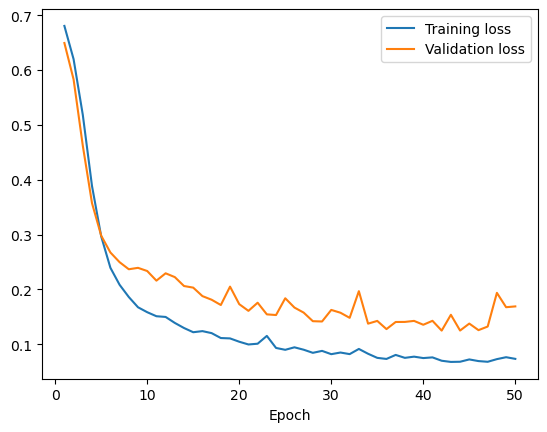

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 80        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 116 (928.00 Byte)
Trainable params: 116 (928.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Mean loss: 0.08506201742342782
Std loss: 0.012465775477296857
Mean train acc: 0.37258241758241756
Std train acc: 0.005412854857244106
Mean val acc: 0.37256637168141593
Std val acc: 0.021615905967193545
Mean time: 0:00:05.339609


In [60]:
h_qy = treina_kfold(xc, model_q, None, 'relu', True, batch_size=15)

<h1>Testando apenas Rede Quântica</h1>

In [45]:
top_5_features = sorted_correlations.iloc[1:6].index.tolist()
x5 = df[top_5_features]
x5 = scaler.fit_transform(x5)
xq5 = np.clip(x5, 0, np.pi)

In [42]:
model_q5 = lambda vqc, act, classic: tf.keras.Sequential([
    tf.keras.layers.Input(5),
    qml.qnn.KerasLayer(vqc, weight_shapes=theta, output_dim=1)])

In [50]:
kf = KFold(n_splits=5, shuffle=True)

Fold #1
Time: 0:06:22.756955
Loss: 0.5263472100035598
15/15 [==============================] - 3s 211ms/step
Train score: 0.5256572605489375 
      accuracy:0.6945054945054945
Validation score: 0.512507471599077 
        accuracy:0.7280701754385965


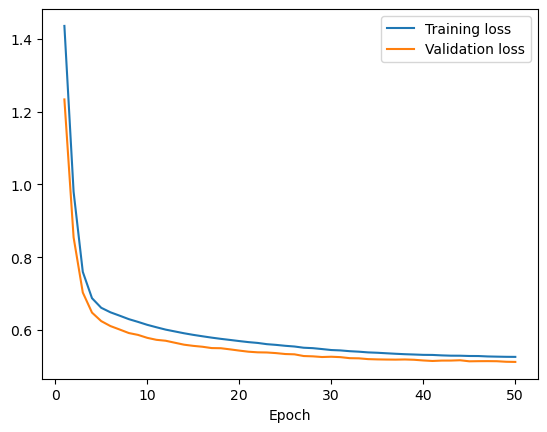

Fold #2
Time: 0:06:14.480726
Loss: 0.5240105617215557
15/15 [==============================] - 3s 222ms/step
Train score: 0.5237780548714019 
      accuracy:0.6923076923076923
Validation score: 0.5329773279658535 
        accuracy:0.6842105263157895


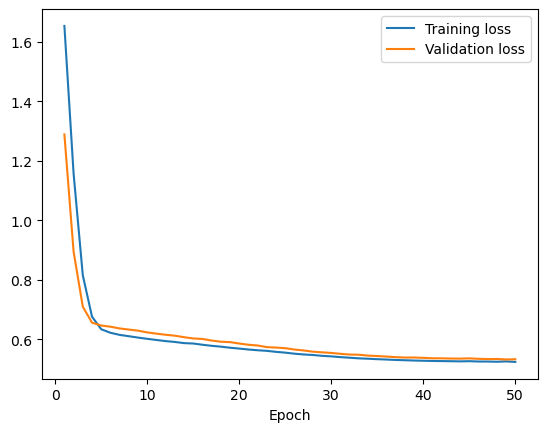

Fold #3
Time: 0:06:12.683269
Loss: 0.5121433801262982
15/15 [==============================] - 3s 184ms/step
Train score: 0.5118815441707988 
      accuracy:0.701098901098901
Validation score: 0.5807203070113534 
        accuracy:0.5964912280701754


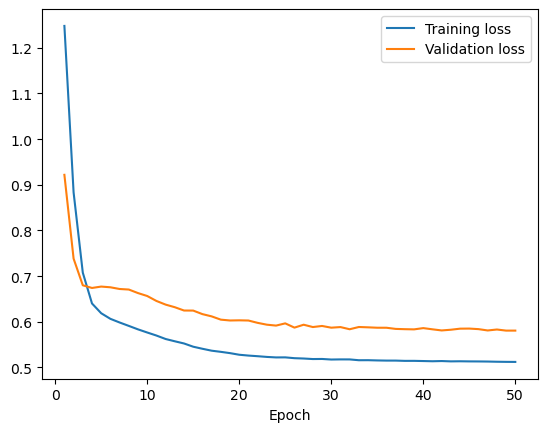

Fold #4
Time: 0:06:11.706563
Loss: 0.54735632443478
15/15 [==============================] - 3s 182ms/step
Train score: 0.5459075145669036 
      accuracy:0.6703296703296703
Validation score: 0.5307278005700362 
        accuracy:0.6754385964912281


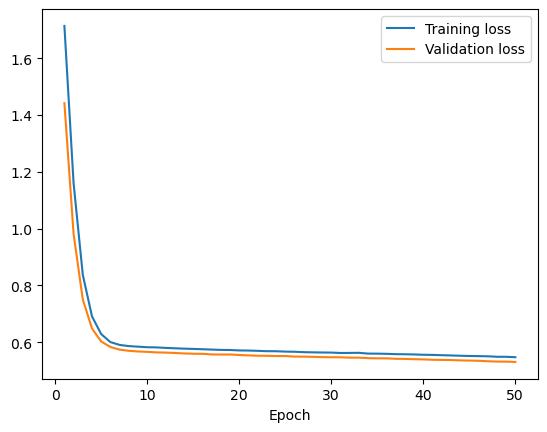

Fold #5
Time: 0:06:09.696923
Loss: 0.5314600541466385
15/15 [==============================] - 3s 186ms/step
Train score: 0.5314317805725232 
      accuracy:0.6864035087719298
Validation score: 0.4905508529823438 
        accuracy:0.7610619469026548


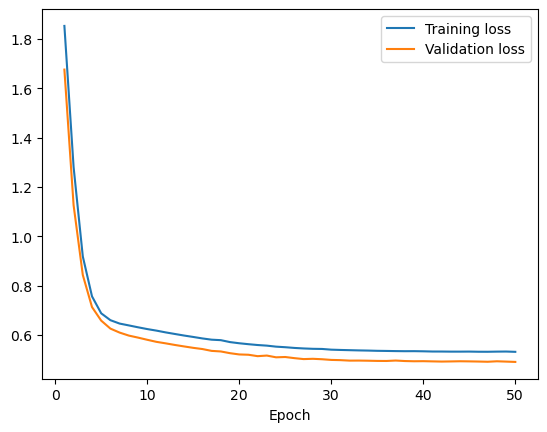

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1)                 20        
                                                                 
Total params: 20 (160.00 Byte)
Trainable params: 20 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Mean loss: 0.5282635060865665
Std loss: 0.012809877237924329
Mean train acc: 0.6889290534027376
Std train acc: 0.011650456166512429
Mean val acc: 0.6890544946436888
Std val acc: 0.06221758505265328
Mean time: 0:06:14.264887


In [61]:
h_q5_qx = treina_kfold(xq5, model_q5, qnn_x, None, False, batch_size=15)

Fold #1
Time: 0:06:08.661830
Loss: 0.46968152841921196
15/15 [==============================] - 3s 174ms/step
Train score: 0.4688542673875997 
      accuracy:0.7670329670329671
Validation score: 0.5517830278789788 
        accuracy:0.6666666666666666


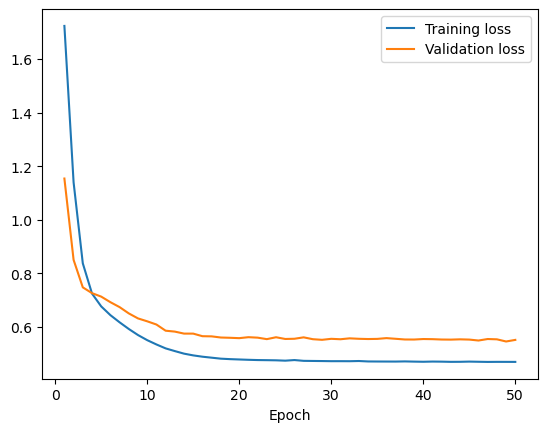

Fold #2
Time: 0:06:04.897078
Loss: 0.4960676578144024
15/15 [==============================] - 3s 211ms/step
Train score: 0.49378475029389934 
      accuracy:0.7516483516483516
Validation score: 0.4928992035096152 
        accuracy:0.7456140350877193


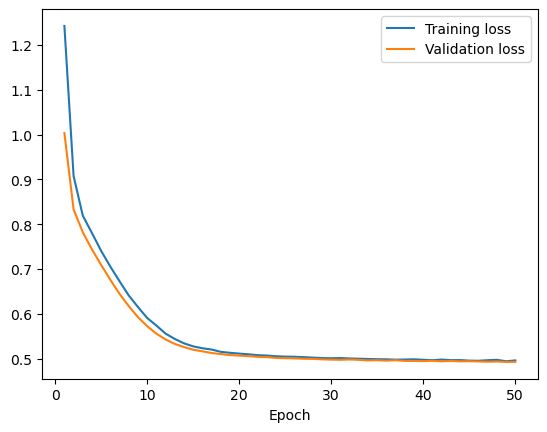

Fold #3
Time: 0:06:03.105872
Loss: 0.4794996047374823
15/15 [==============================] - 3s 183ms/step
Train score: 0.47823877452494024 
      accuracy:0.7934065934065934
Validation score: 0.4991203044590197 
        accuracy:0.7543859649122807


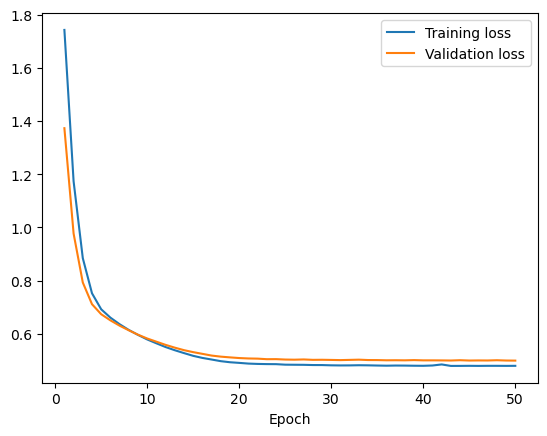

Fold #4
Time: 0:06:08.297119
Loss: 0.49767041287740305
15/15 [==============================] - 3s 181ms/step
Train score: 0.4970943058585073 
      accuracy:0.789010989010989
Validation score: 0.450781270077354 
        accuracy:0.868421052631579


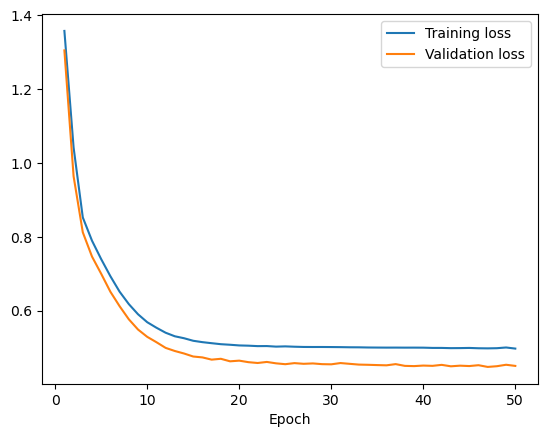

Fold #5
Time: 0:06:20.325468
Loss: 0.4923301546935603
15/15 [==============================] - 3s 198ms/step
Train score: 0.49195268907045064 
      accuracy:0.75
Validation score: 0.4474721107862692 
        accuracy:0.831858407079646


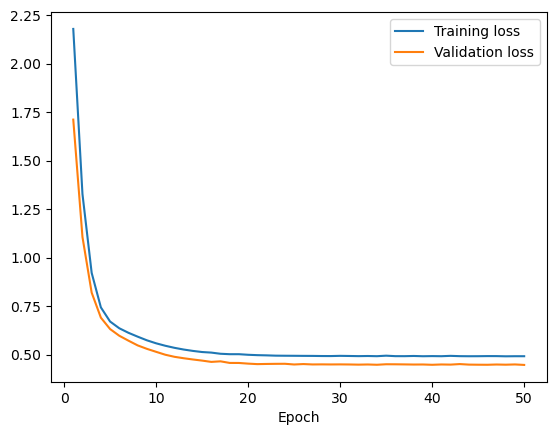

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1)                 20        
                                                                 
Total params: 20 (160.00 Byte)
Trainable params: 20 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Mean loss: 0.487049871708412
Std loss: 0.012048481536304534
Mean train acc: 0.7702197802197802
Std train acc: 0.020338578386913553
Mean val acc: 0.7733892252755783
Std val acc: 0.07901263038574503
Mean time: 0:06:09.057473


In [62]:
h_q5_y = treina_kfold(x5, model_q5, qnn_y, None, False)

In [ ]:
h_q5_z = treina_kfold(x5, model_q5, qnn_z, None, False)